In [131]:
import pandas as pd
from ast import literal_eval
import numpy as np
np.seterr(all="raise")

today = "2019-11-04"

df = pd.read_parquet(f"out/{today}-1d-test.parquet")
df["total_params1"] = df["shape1[0]"]# * df["shape1[1]"]
df["total_params2"] = df["shape2[0]"]# * df["shape2[1]"]
print(len(df))
df.tail()

9213


,shape1[0],shape2[0],mode,seed,fft_time,direct_time,total_params1,total_params2
9208,13709,16,full,3069,0.000375,0.000387,13709,16
9209,13709,16,same,3069,0.000391,0.000383,13709,16
9210,23936,2743,valid,3070,0.001740,0.011936,23936,2743
9211,23936,2743,full,3070,0.000812,0.015616,23936,2743
9212,23936,2743,same,3070,0.000949,0.013578,23936,2743


In [132]:
from functools import lru_cache

def _prod(iterable):
    r = 1
    for it in iterable:
        r *= it
    return r
    
sum_builtin = sum

# def _get_constant(mode, x_ndim, x_size, h_size):
#     if mode == 'full':
#         big_O_constant = 10963.92823819 if x_ndim == 1 else 8899.1104874
#     elif mode == 'same':
#         oneD_big_O = {True: 7183.41306773, False: 856.78174111}
#         big_O_constant = oneD_big_O[h_size <= x_size] if x_ndim == 1 \
#                                                       else 34519.21021589
#     elif mode == 'valid':
#         big_O_constant = 41954.28006344 if x_ndim == 1 else 66453.24316434
#     else:
#         raise ValueError('mode is invalid')
#     return big_O_constant

@lru_cache()
def _get_constant(mode, x_ndim, x_size, h_size):
    df = pd.read_csv("constants.csv")
    if mode != "same":
        idx = (df["ndim"] == 1) & (df["mode"] == mode)
    else: 
        cond = "smaller_kernel" if h_size <= x_size else "bigger_kernel"
        idx = (df["ndim"] == 1) & (df["mode"] == "same") & (df["cond"] == cond)
    assert idx.sum() == 1
    return df[idx]["constant"].values.item()

In [133]:
def _fftconv_faster(x_shape, h_shape, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    x_size = _prod(x_shape)
    x_ndim = len(x_shape)
    h_size = _prod(h_shape)
    h_ndim = len(h_shape)
    if mode == 'full':
        out_shape = [n + k - 1 for n, k in zip(x_shape, h_shape)]
    elif mode == 'same':
        out_shape = x_shape
    elif mode == 'valid':
        out_shape = [n - k + 1 for n, k in zip(x_shape, h_shape)]
    else:
        raise ValueError('mode is invalid')
    out_shape = [o if o > 0 else -o + 2 for o in out_shape]

    # see whether the Fourier transform convolution method or the direct
    # convolution method is faster (discussed in scikit-image PR #1792)
    direct_time = min(x_size, h_size) * _prod(out_shape)
    fft_time = sum_builtin(n * np.log(n) for n in (x_shape + h_shape +
                                               tuple(out_shape)))
    big_O_constant = _get_constant(mode, x_ndim, x_size, h_size)
    return "fft" if big_O_constant * fft_time < direct_time else "direct"

def estimate_faster_method(row):
    x_shape = (row["shape1[0]"], )#row["shape1[1]"])
    h_shape = (row["shape2[0]"], )#row["shape2[1]"])
    mode = row["mode"]
    return _fftconv_faster(x_shape, h_shape, mode)

In [134]:
fft_faster = df["fft_time"] < df["direct_time"]
df["faster"] = ""
df.loc[fft_faster, "faster"] = "fft"
df.loc[~fft_faster, "faster"] = "direct"

df["faster_est"] = df.apply(estimate_faster_method, axis=1)

df["correct"] = (df.faster == df.faster_est)
acc = df["correct"].sum() / len(df)
print(f"Predicted fastest method {100 * acc:0.2f}% of the time")

Predicted fastest method 78.29% of the time


**Goal for accuracy on predicting fastest**: >90% -- that's the performance seen with code from SciPy 1.3 (after uncommenting `_get_constant` function above)

In [135]:
idx = (df["mode"] == "same") & (df["shape1[0]"] < df["shape2[0]"])
df["cond"] = "a"
df.loc[idx, "cond"] = "bigger_kernel"
idx = (df["mode"] == "same") & (df["shape1[0]"] >= df["shape2[0]"])
df.loc[idx, "cond"] = "smaller_kernel"

In [136]:
show = df.pivot_table(
    columns="cond",
    index="mode",
    values="correct",
).reset_index()
show.melt(id_vars=["mode"]).dropna()

,mode,cond,value
0,full,a,0.815695
2,valid,a,0.834907
4,same,bigger_kernel,0.577419
7,same,smaller_kernel,0.821170


In [137]:
wrong_idx = df.faster != df.faster_est
wrong =  df[wrong_idx].copy()
wrong["ratio"] = wrong.fft_time / wrong.direct_time
idx = wrong.ratio < 1
wrong.loc[idx, "ratio"] = 1 / wrong.loc[idx, "ratio"]

vals = wrong.copy()
vals.sort_values(by="direct_time", inplace=True)
vals.tail(n=10)

,shape1[0],shape2[0],mode,seed,fft_time,direct_time,total_params1,total_params2,faster,faster_est,correct,cond,ratio
6101,161,71558,same,2033,0.000985,0.123005,161,71558,fft,direct,False,bigger_kernel,124.920339
4124,197,78382,same,1374,0.001707,0.128398,197,78382,fft,direct,False,bigger_kernel,75.225730
2966,188,74489,same,988,0.000977,0.131676,188,74489,fft,direct,False,bigger_kernel,134.803515
2987,130,85813,same,995,0.001593,0.136893,130,85813,fft,direct,False,bigger_kernel,85.940877
4679,164,87114,same,1559,0.001876,0.148354,164,87114,fft,direct,False,bigger_kernel,79.085155
7880,128,93258,same,2626,0.001608,0.150543,128,93258,fft,direct,False,bigger_kernel,93.627521
6449,209,84788,same,2149,0.001027,0.153122,209,84788,fft,direct,False,bigger_kernel,149.080780
6452,186,93609,same,2150,0.002279,0.154816,186,93609,fft,direct,False,bigger_kernel,67.930223
8294,214,68070,same,2764,0.001412,0.172973,214,68070,fft,direct,False,bigger_kernel,122.530316
7694,215,92835,same,2564,0.001283,0.173666,215,92835,fft,direct,False,bigger_kernel,135.341509


In [138]:
vals["correct"] = (vals["faster"] == vals["faster_est"])#.astype(float)
print(vals["faster"].unique())
print(vals["faster_est"].unique())
print(vals.correct.unique())

vals.pivot_table(
    index="mode",
    values="correct",
    aggfunc=np.mean,
)

['direct' 'fft']
['fft' 'direct']
[False]


,correct
mode,
full,False
same,False
valid,False


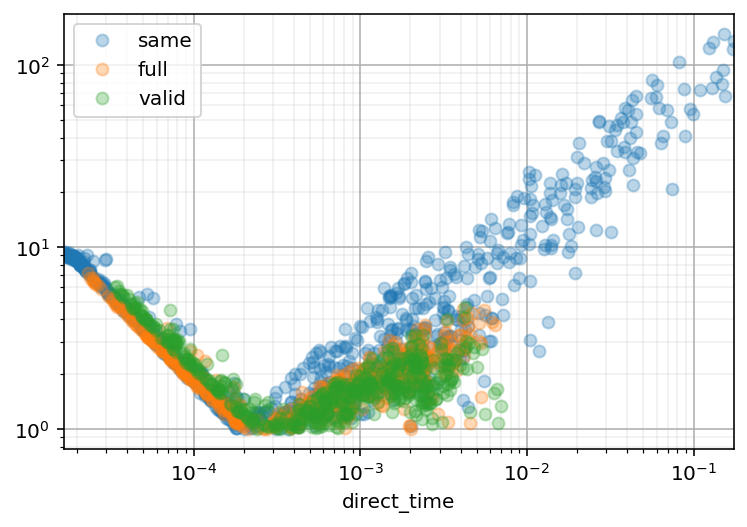

In [147]:
fig, ax = plt.subplots()
for mode in vals["mode"].unique():
    ax = vals[vals["mode"] == mode].plot(
        x="direct_time", y="ratio", style="o", alpha=0.3,
        ax=ax, label=mode,
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.grid()
ax.grid(which="minor", alpha=0.2)

In [148]:
vals.ratio.max()

149.0807799442897

In [149]:
vals.direct_time.min()

1.6689300537109375e-05

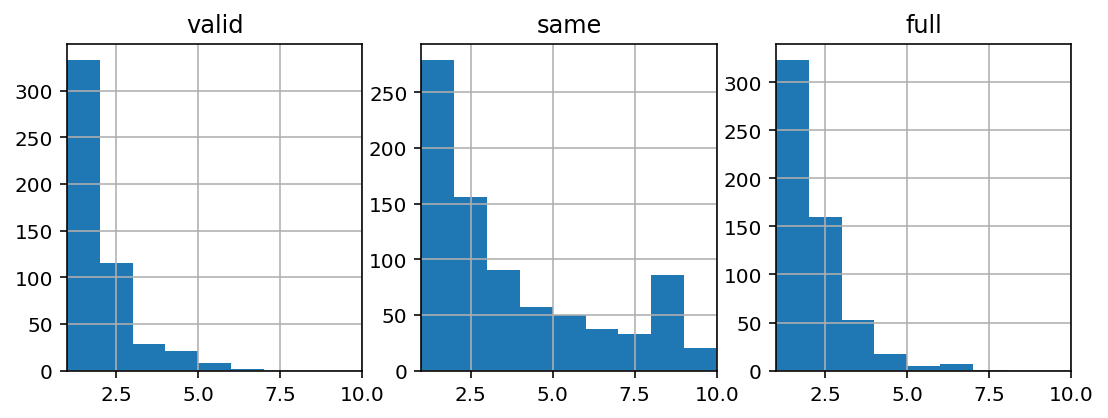

In [150]:
lims = range(int(wrong.ratio.max() + 1))

import matplotlib.pyplot as plt
w = 3
fig, axs = plt.subplots(ncols=3, figsize=(3*w, w))
for mode, ax in zip(["valid", "same", "full"], axs):
    show = wrong[wrong["mode"] == mode]
    ax = show.ratio.hist(bins=lims, ax=ax)
    _ = ax.set_xlim(1, 10)
    _ = ax.set_title(mode)
    _ = ax.set_xlim(1, 10)

**Goal for this histogram:** `ratio.max() < 5` approximately. That's the performance with SciPy 1.3 (again, after un-commenting `_get_constants` above).

In [151]:
for i in range(2, 20 + 1):
    prob = (wrong.ratio <= i).sum() / len(wrong)
    msg = f"P(ratio <= {i}) = {100 * prob:0.1f}%"
    print(msg)

P(ratio <= 2) = 46.8%
P(ratio <= 3) = 68.3%
P(ratio <= 4) = 76.9%
P(ratio <= 5) = 81.7%
P(ratio <= 6) = 84.8%
P(ratio <= 7) = 87.1%
P(ratio <= 8) = 88.8%
P(ratio <= 9) = 93.1%
P(ratio <= 10) = 94.0%
P(ratio <= 11) = 94.5%
P(ratio <= 12) = 94.7%
P(ratio <= 13) = 95.0%
P(ratio <= 14) = 95.2%
P(ratio <= 15) = 95.5%
P(ratio <= 16) = 95.5%
P(ratio <= 17) = 95.7%
P(ratio <= 18) = 95.9%
P(ratio <= 19) = 96.1%
P(ratio <= 20) = 96.3%


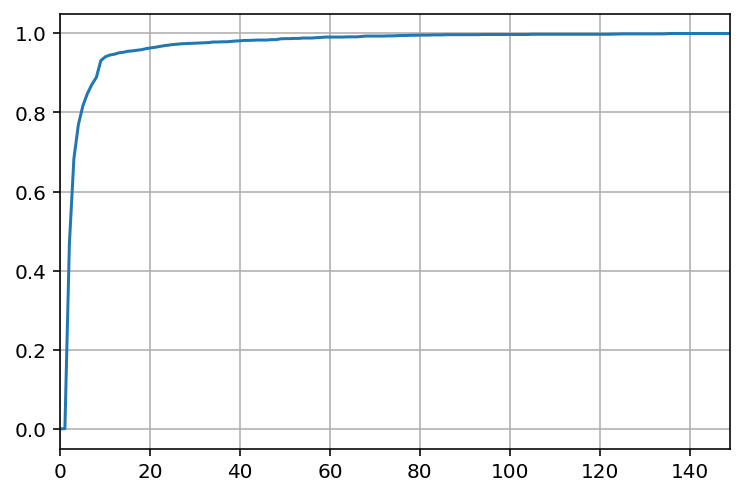

In [152]:
cdf = {i: (wrong.ratio <= i).sum() / len(wrong) for i in lims}
ax = pd.Series(cdf).plot()
ax.grid()

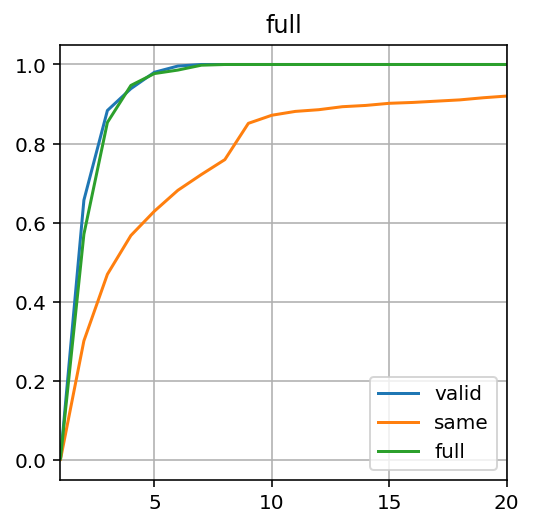

In [156]:
lims = range(int(wrong.ratio.max() + 1))

import matplotlib.pyplot as plt
w = 4
fig, ax = plt.subplots(figsize=(w, w))
for mode in ["valid", "same", "full"]:
    show = wrong[wrong["mode"] == mode]
    cdf = {i: (show.ratio <= i).sum() / len(show) for i in lims}
    ax = pd.Series(cdf).plot(ax=ax, label=mode)
ax.grid()
ax.legend(loc="best")
_ = ax.set_title(mode)
_ = ax.set_xlim(1, 20)